# Linear models for predicting MLB salary in 6 years with rookie stats

Main notebook utilized for the ultimate presenation of Project 2 and for the Summary document.

### Future notes / todos
* Distribution of log(salary) is somewhat normal. Need to confirm if this is OK or not.
* Should put age into feature set and see if the younger the rookie then better chance of a higher salary.
* Need some type of pairplot as probably some of my features are correlated like HRs and TBs.
* Probably need to get more data

In [43]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from  matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from math import sqrt

# %config InlineBackend.figure_format = 'svg'
%matplotlib inline

%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [44]:
# set paths of the data files
PATH_S = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/hist_salaries.csv'
PATH_R = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookies.csv'
PATH_RS = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/agg_df_stats.csv'

In [45]:
def mean_mse_Lasso(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [46]:
def mean_mse_Ridge(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [47]:
# get the salary and stats data
df_stats = pd.read_csv(PATH_RS, index_col = 0)
df_salary = pd.read_csv(PATH_S, index_col = 0)

Merge the stats and salary data frames together. `df_stats` has only rookie batters from 1985-2017. `df_salary` has all MLB salaries from 1985-2017 as long as the player was paid for 6 years from rookie season.

In [48]:
salary_stats_df = df_stats.merge(df_salary, on='name_year')
salary_stats_df = salary_stats_df.loc[:,['Year_x', 'Age_x', 'name_x', 'debut', 'position', 'G', 'PA', 'AB', 'R',
       'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'name_year',
        'Salary', 'SrvTm', 'today_salary']]
salary_stats_df.rename(columns={'Year_x':'rookie_year', 'Age_x':'age', 'name_x':'name'}, inplace=True)
salary_stats_df['log_today_salary'] = np.log10(salary_stats_df.today_salary) # log transform the salary
salary_stats_df.shape

(919, 23)

Create `X` and `y`, and make a train / test split of 20%.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


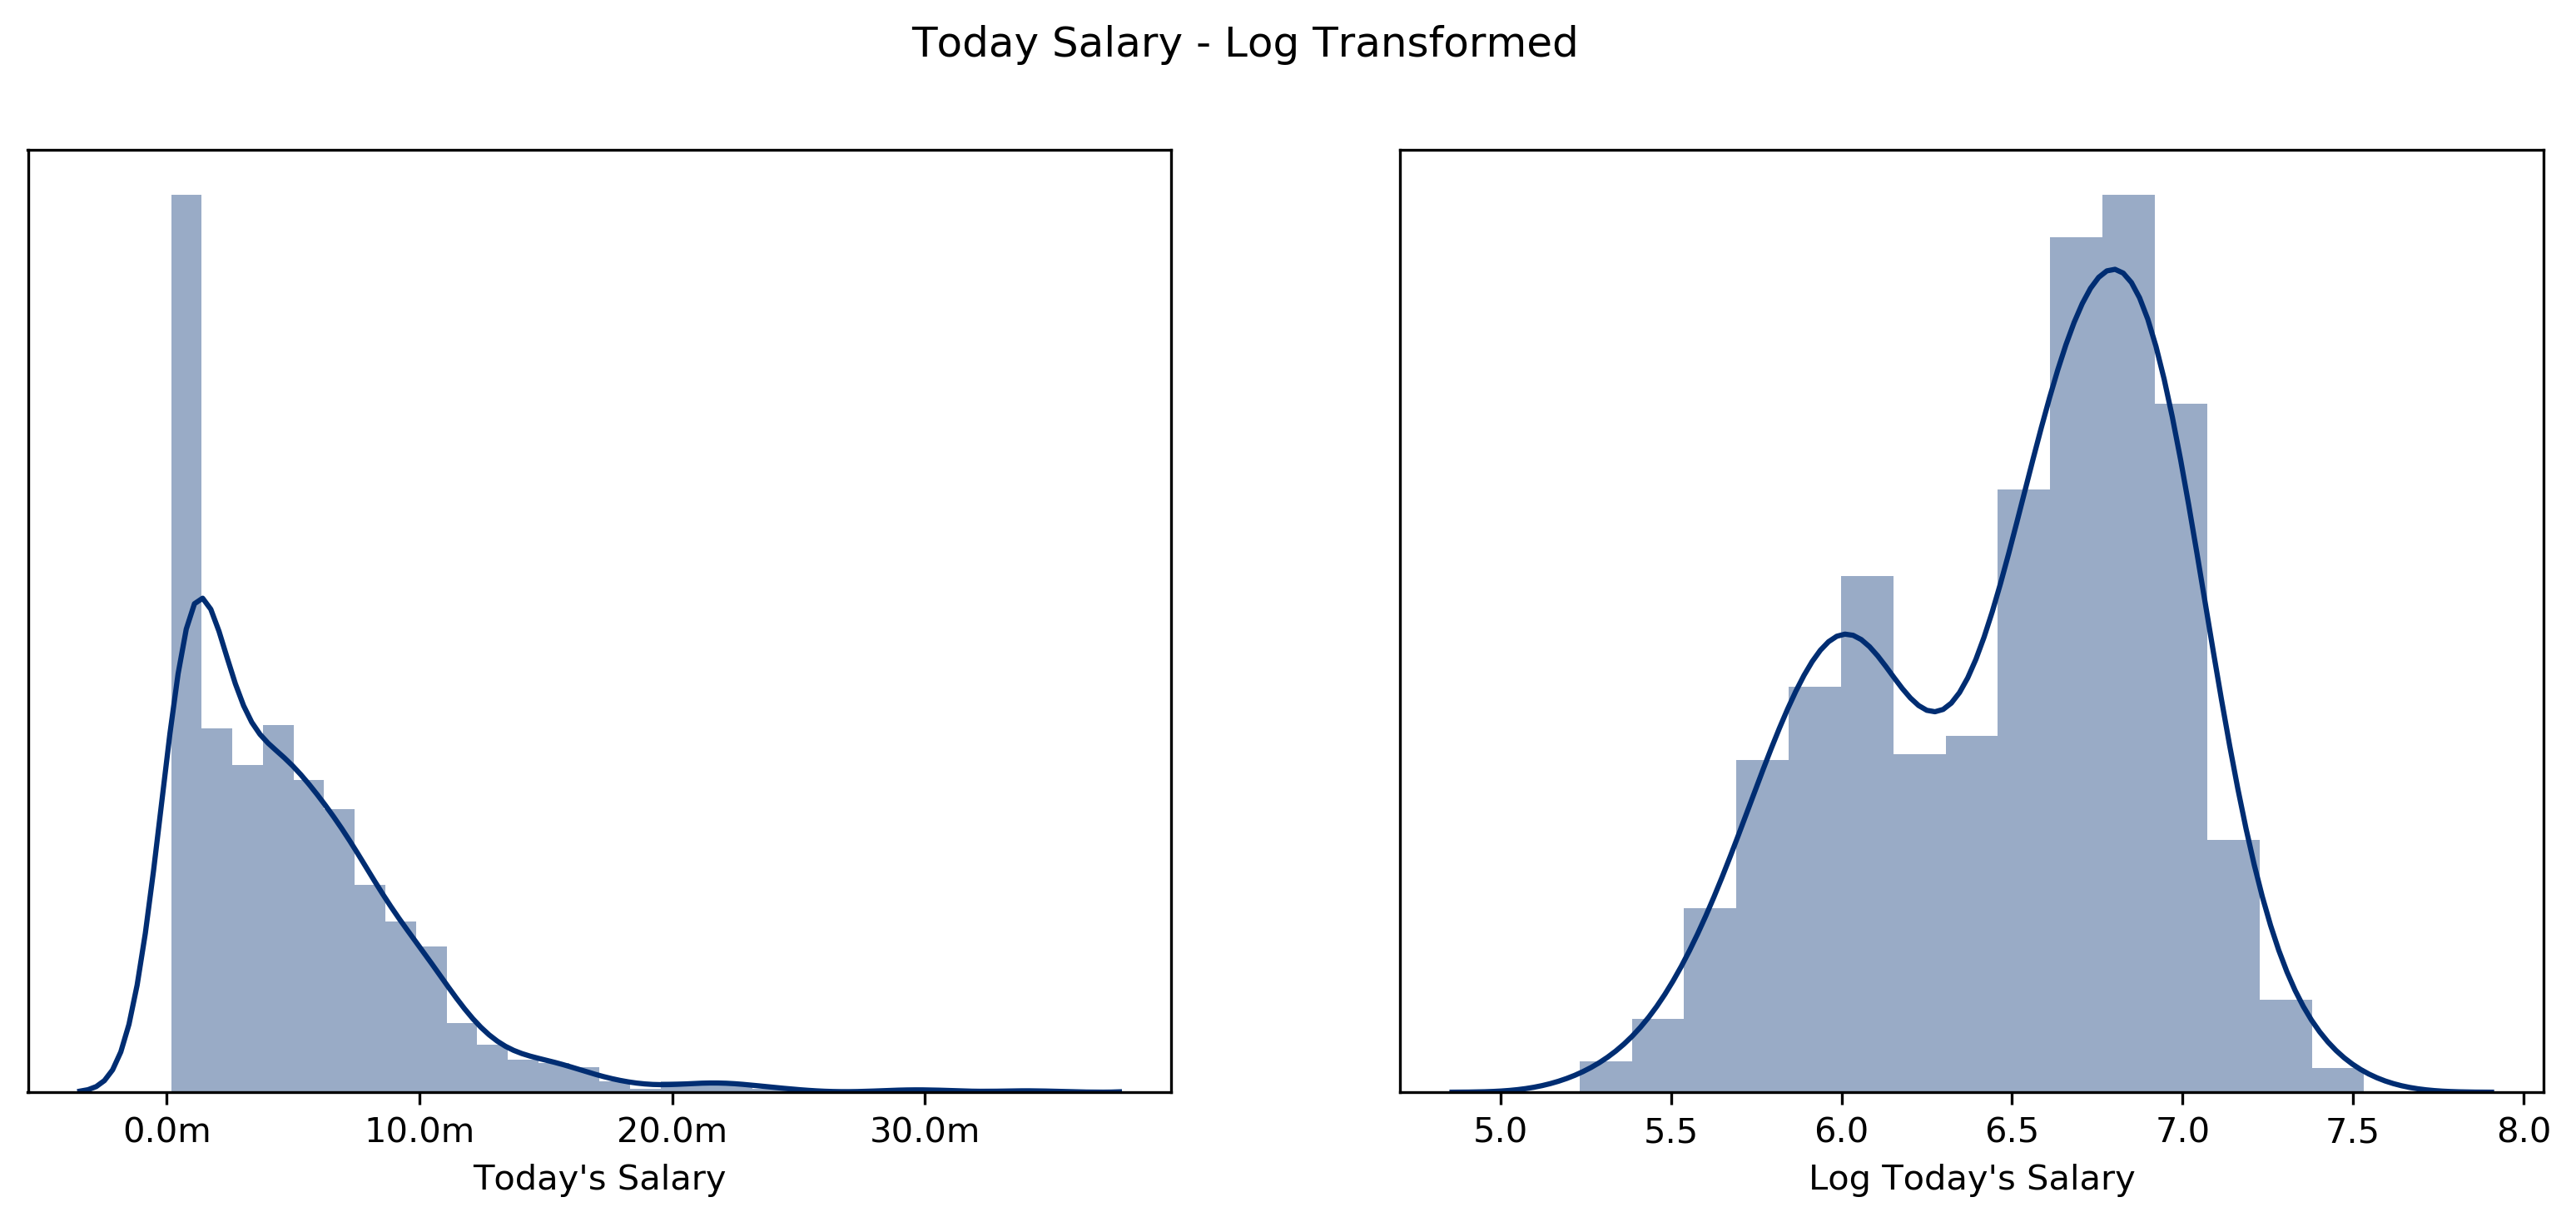

In [49]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.distplot(salary_stats_df.today_salary, color='#002D72')
plt.xlabel('Today\'s Salary')
plt.yticks([])

# convert tick labels to millions
ax = plt.gca()
vals = ax.get_xticks()
ax.set_xticklabels(['{}m'.format(x/1e6) for x in vals])


plt.subplot(1,2,2)
sns.distplot(salary_stats_df.log_today_salary, color='#002D72')
plt.xlabel('Log Today\'s Salary')
plt.yticks([])

plt.suptitle('Today Salary - Log Transformed')

plt.savefig('misc/salary_comparison.png');

In [50]:
y = salary_stats_df.log_today_salary

X = salary_stats_df.loc[:,['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'age']]
print('X sample:',X.shape)
print('y sample:',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print('X train:', X_train.shape)
print('y train:', y_train.shape)

X sample: (919, 14)
y sample: (919,)
X train: (735, 14)
y train: (735,)


In [51]:
X_train.describe()

,G,PA,AB,R,H,SB,HR,TB,2B,3B,RBI,BB,SO,age
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,87.546939,308.519728,277.575510,36.733333,73.261224,6.122449,6.795918,111.812245,13.872109,2.145578,32.273469,23.840816,52.493878,23.987755
std,36.252260,159.861680,144.128744,22.684596,41.639687,9.298192,6.331809,65.752095,8.799614,2.305491,21.019649,16.201825,31.410869,2.000303
min,3.000000,9.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000
25%,57.000000,179.000000,161.500000,19.500000,41.000000,1.000000,2.000000,61.000000,7.000000,0.000000,16.500000,12.000000,29.000000,23.000000
50%,85.000000,275.000000,244.000000,31.000000,64.000000,3.000000,5.000000,95.000000,12.000000,2.000000,27.000000,20.000000,46.000000,24.000000
75%,115.000000,429.500000,384.000000,51.000000,101.000000,8.000000,9.000000,154.500000,19.000000,3.000000,44.000000,32.000000,70.000000,25.000000
max,162.000000,734.000000,684.000000,122.000000,209.000000,110.000000,37.000000,365.000000,47.000000,12.000000,130.000000,91.000000,185.000000,32.000000


Combine `X` and `y` training data sets and calculate the correlation matrix.

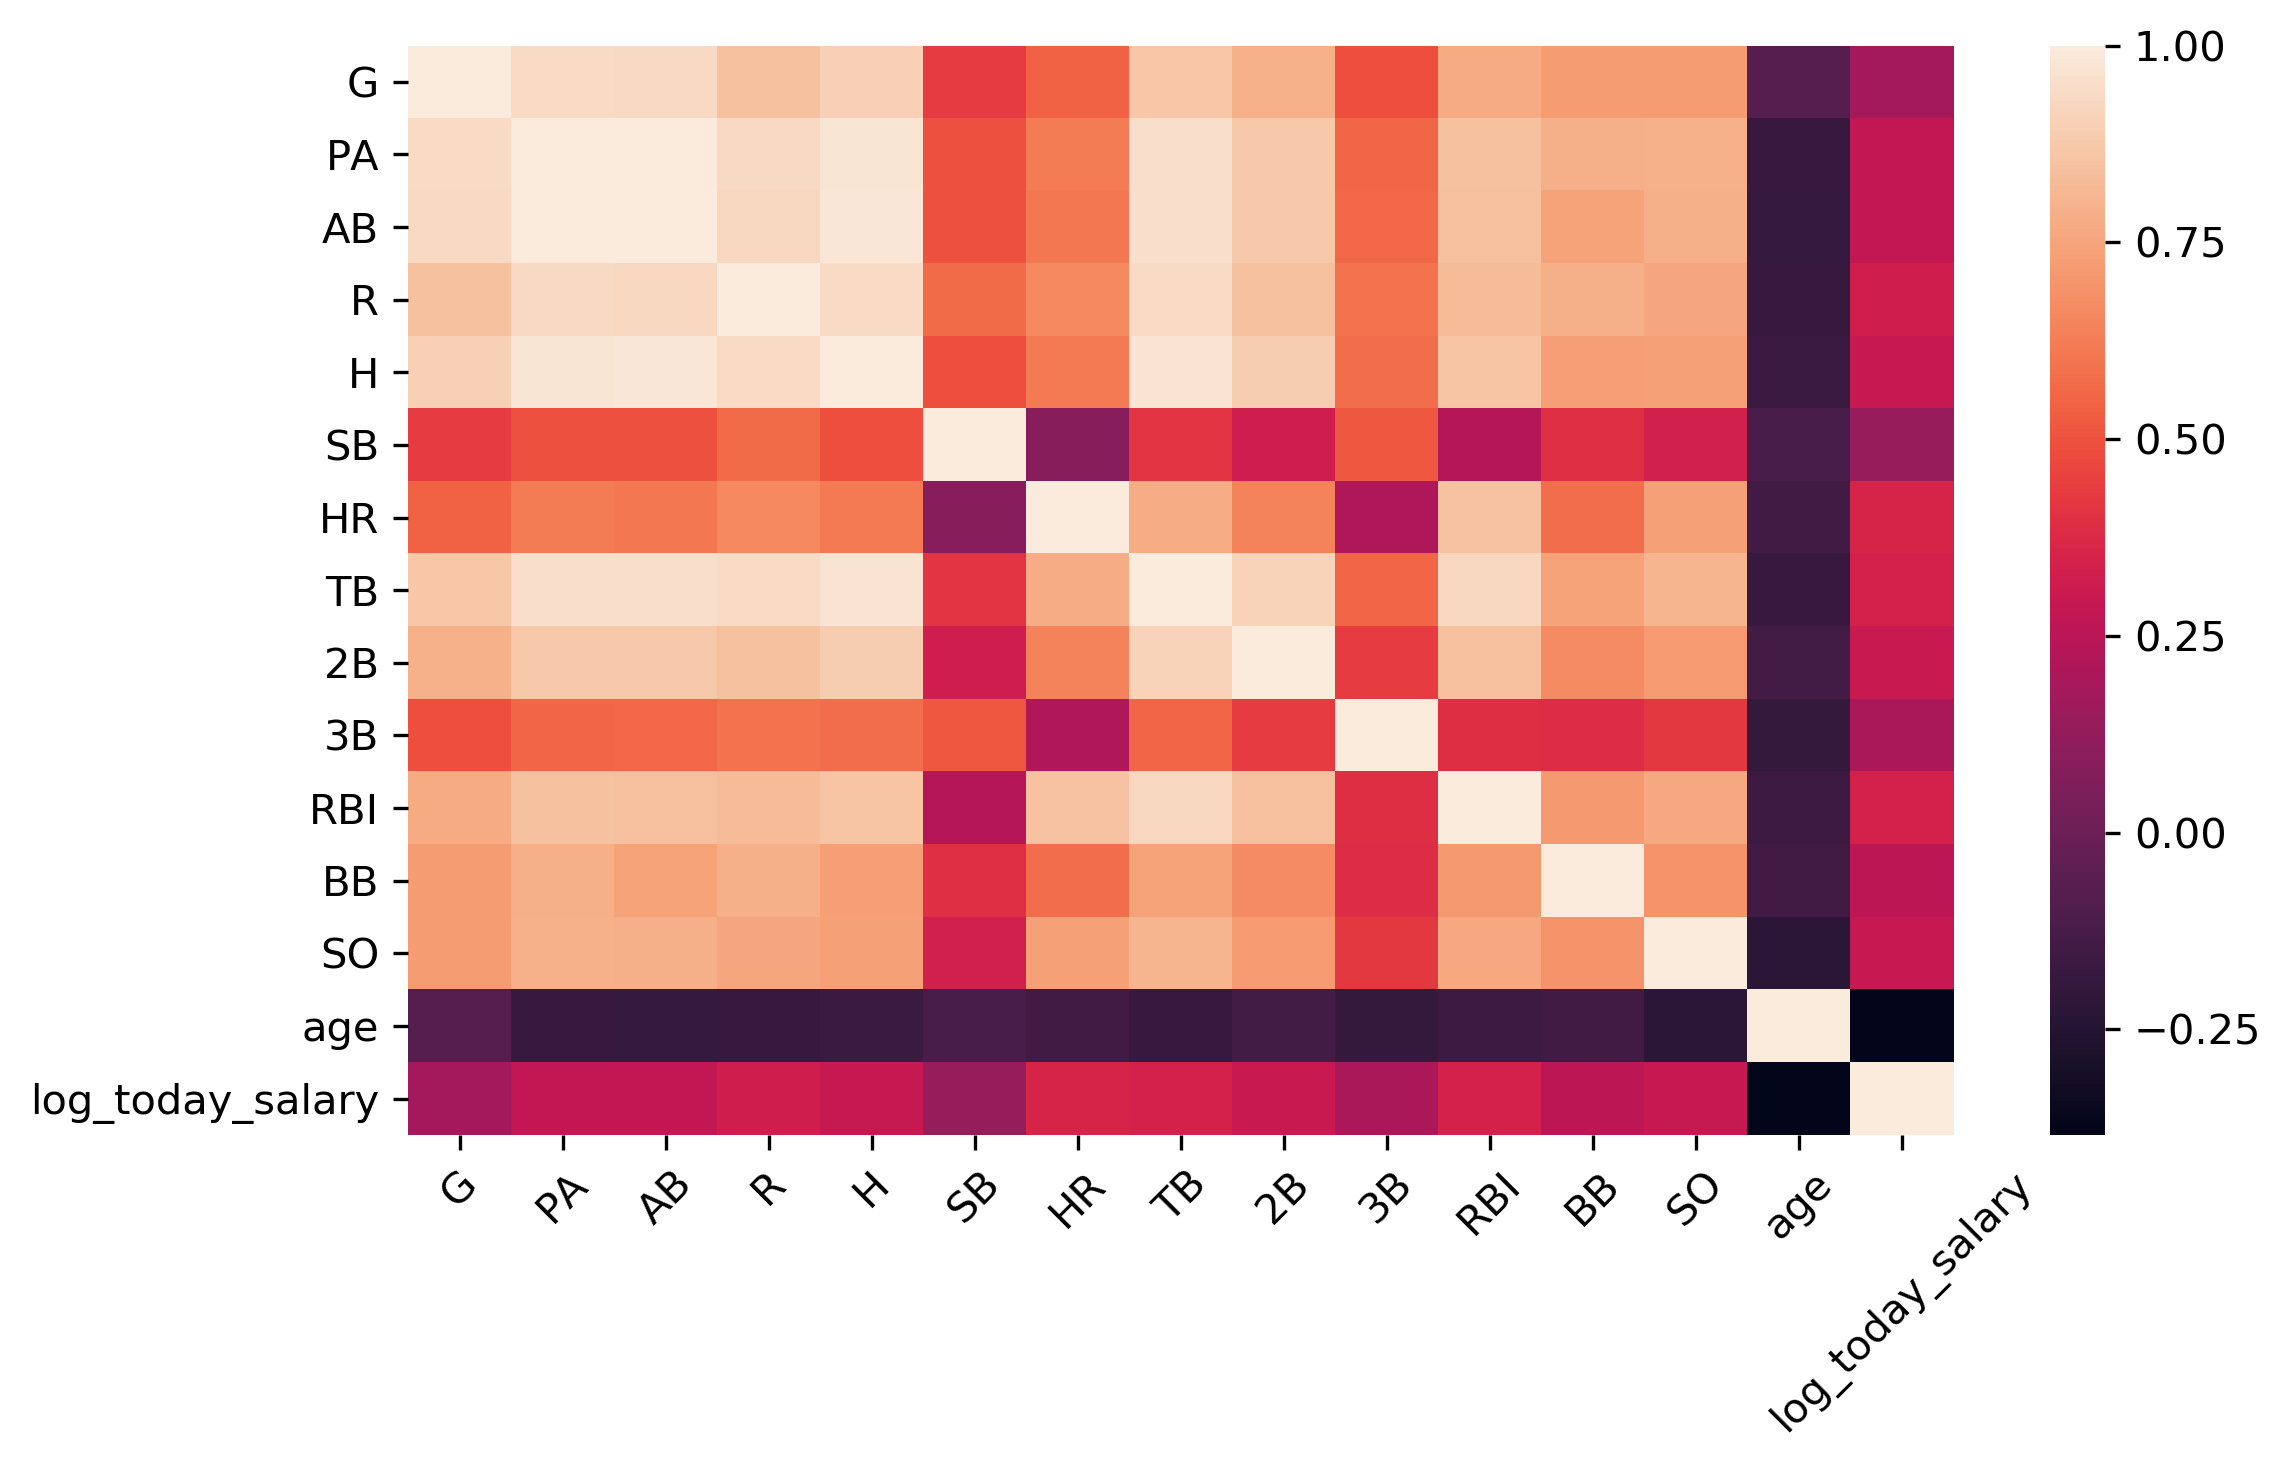

In [52]:
Xy = pd.concat([X_train, y_train], axis=1)
# sns.pairplot(Xy);

plt.figure(figsize=(8,5))
corr = Xy.corr()
sns.heatmap(corr)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('misc/corr_heatmap.png');

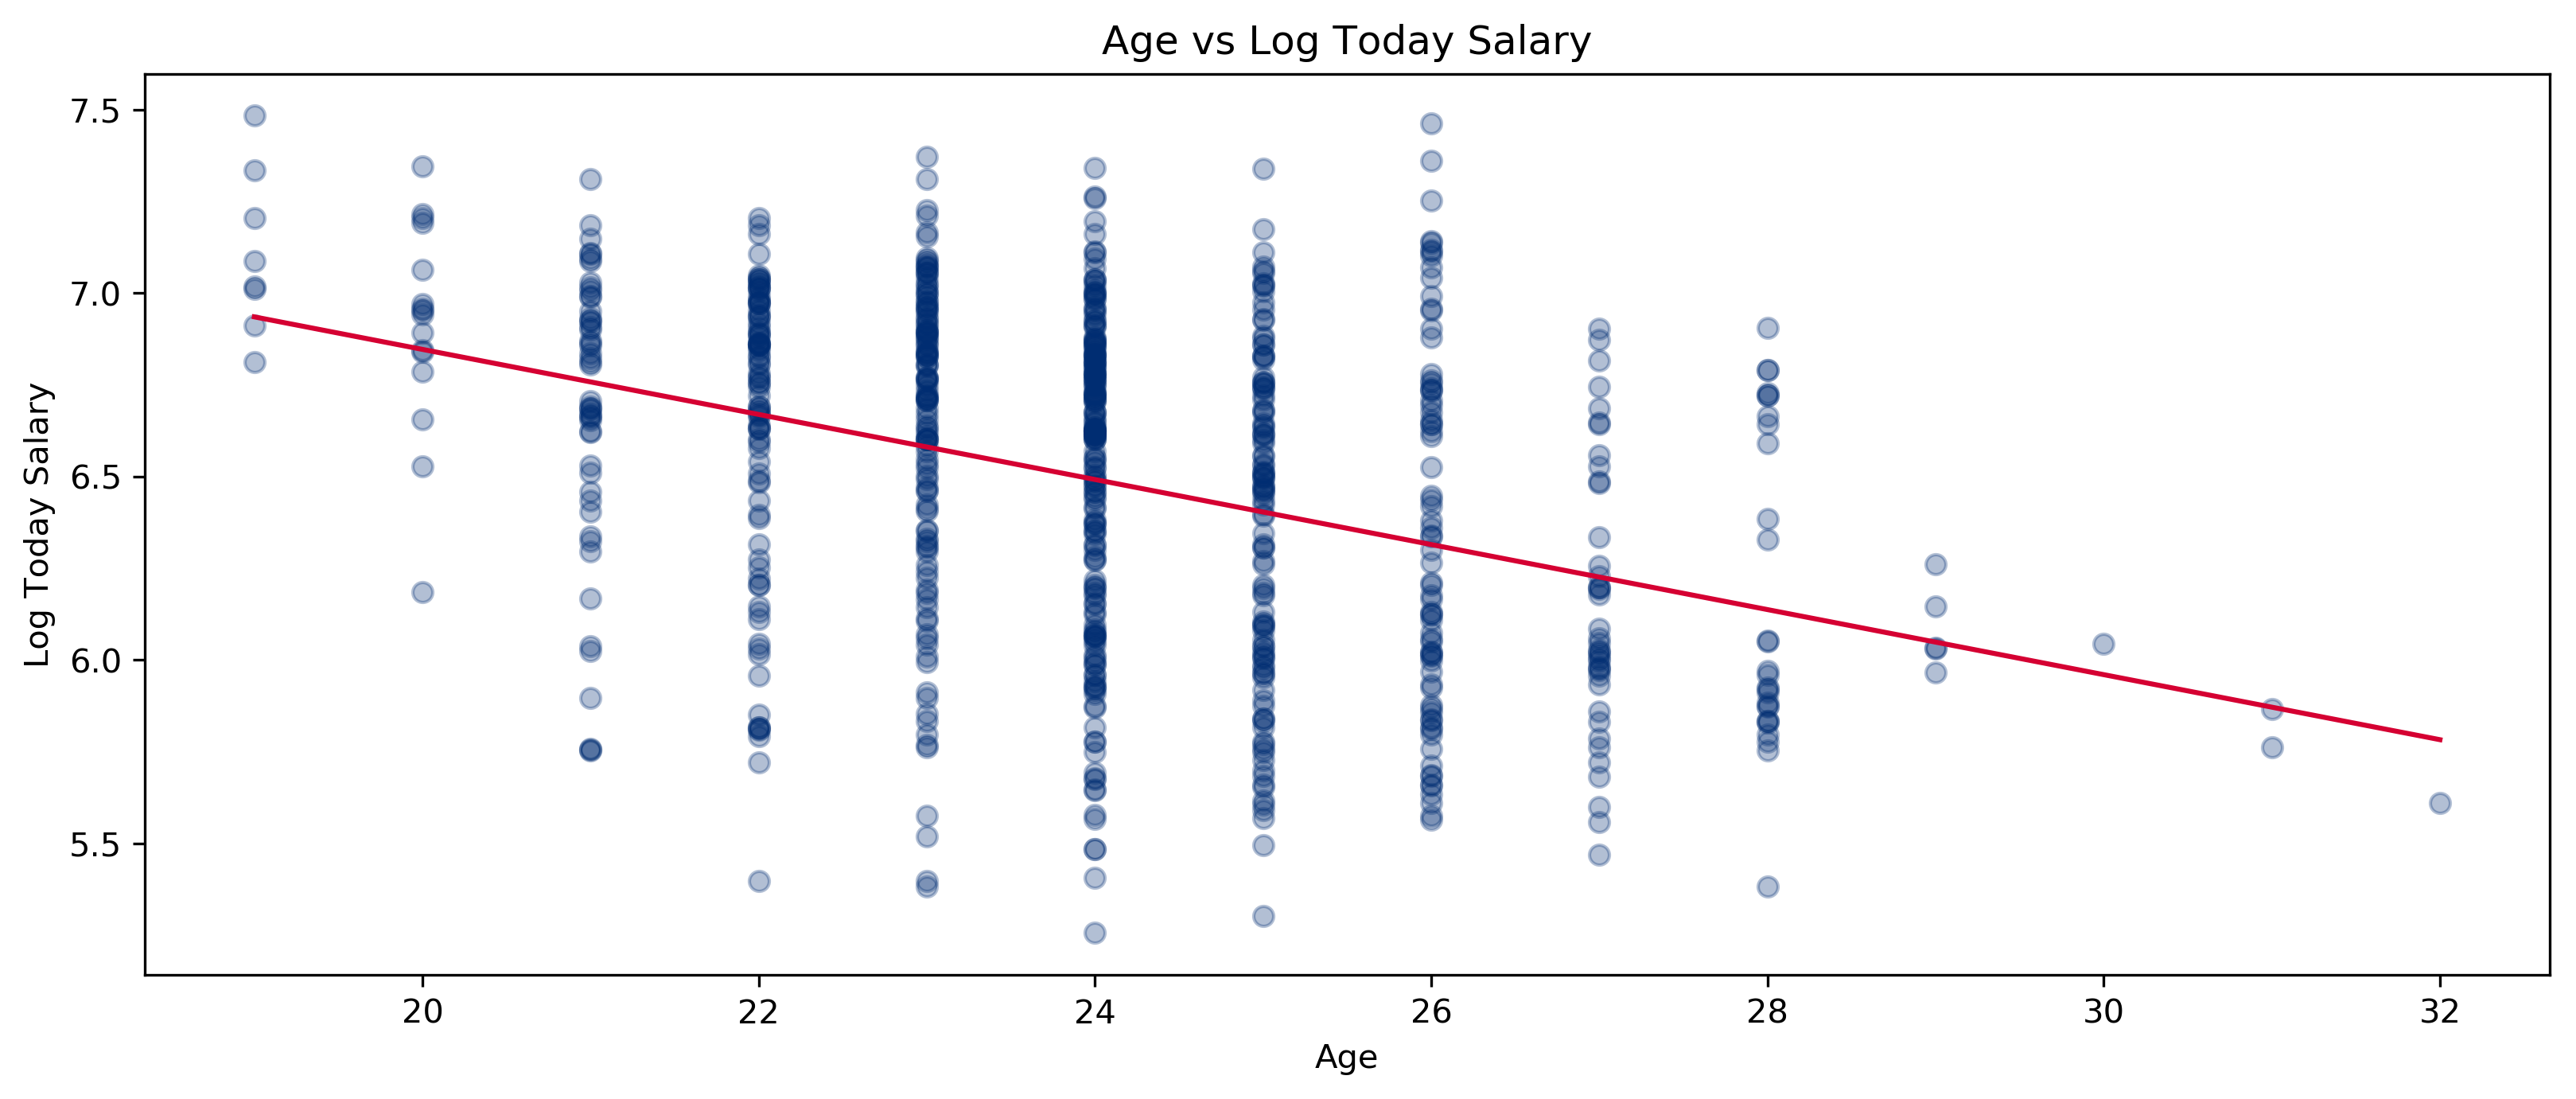

In [53]:
plt.figure(figsize=(13,5))
plt.scatter(Xy.age, Xy.log_today_salary, color='#002D72', alpha=0.3)
plt.plot(np.unique(Xy.age), np.poly1d(np.polyfit(Xy.age, Xy.log_today_salary, 1))(np.unique(Xy.age)), color='#D50032')
plt.xlabel('Age')
plt.ylabel('Log Today Salary')
plt.title('Age vs Log Today Salary')
plt.savefig('misc/age_v_salary.png');

HRs and age of rookie year are somewhat correlated with salary in 6 years. Whereas, games (G) and stolen bases (SB) are less related to salary in 6 years.

Build a basic linear regression model with all features as a baseline to compare against the Lasso models

In [54]:
model_results = pd.Series(name='MSE')

Add a 10-fold cross-validation linear regression model.

In [55]:
lin_model = LinearRegression()
scores = cross_val_score(lin_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
model_results['linear model - cv10'] = np.mean(-scores)
model_results

linear model - cv10    0.163087
Name: MSE, dtype: float64

Build a Lasso model with standard scaling.

Now perform a 10-fold cross validation for same range of alphas.

In [56]:
alphas = [10**a for a in range(-2,5)]

In [57]:
cv_lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, alphas=alphas, tol=0.001))
cv_lasso.fit(X_train, y_train)
model_results['lasso cv - ' + str(cv_lasso.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso, 'lassocv')
model_results.sort_values()

lasso cv - 0.01        0.162541
linear model - cv10    0.163087
Name: MSE, dtype: float64

Now 2-5 degree polynomial features and perform a 10-fold cross validation.

In [58]:
for degrees in range(2,6):
    cv_lasso_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), LassoCV(cv=10, alphas=alphas,tol=0.001))
    cv_lasso_poly.fit(X_train, y_train)
    model_results['lasso poly ' + str(degrees) + ' cv - ' + str(cv_lasso_poly.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso_poly, 'lassocv')

In [60]:
model_results = model_results.sort_values().reset_index()
model_results['MSE'] = np.sqrt(model_results['MSE'])
model_results

,index,MSE
0,lasso poly 3 cv - 0.01,0.401520
1,lasso poly 2 cv - 0.01,0.401682
2,lasso poly 4 cv - 0.01,0.401850
3,lasso poly 5 cv - 0.01,0.402899
4,lasso cv - 0.01,0.403164
5,linear model - cv10,0.403841


In [15]:
## Talk to Spencer tomorrow possibly
# ## Broken need to use the cv_values_
# for degrees in range(2,3):
#     cv_ridge_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), RidgeCV(cv=10, alphas=alphas))
#     cv_ridge_poly.fit(X_train, y_train)
# #     model_results['ridge poly ' + str(degrees) + ' cv - ' + str(cv_ridge_poly.get_params()['ridgecv'].alpha_)] = mean_mse(cv_ridge_poly, 'ridgecv')

In [16]:
# cv_ridge_poly.get_params()['ridgecv'].alpha_

In [17]:
# model_results.sort_values()

In [80]:
best_model = make_pipeline(PolynomialFeatures(3), StandardScaler(), Lasso(alpha=0.01, tol=0.001))
best_model.fit(X_train, y_train);

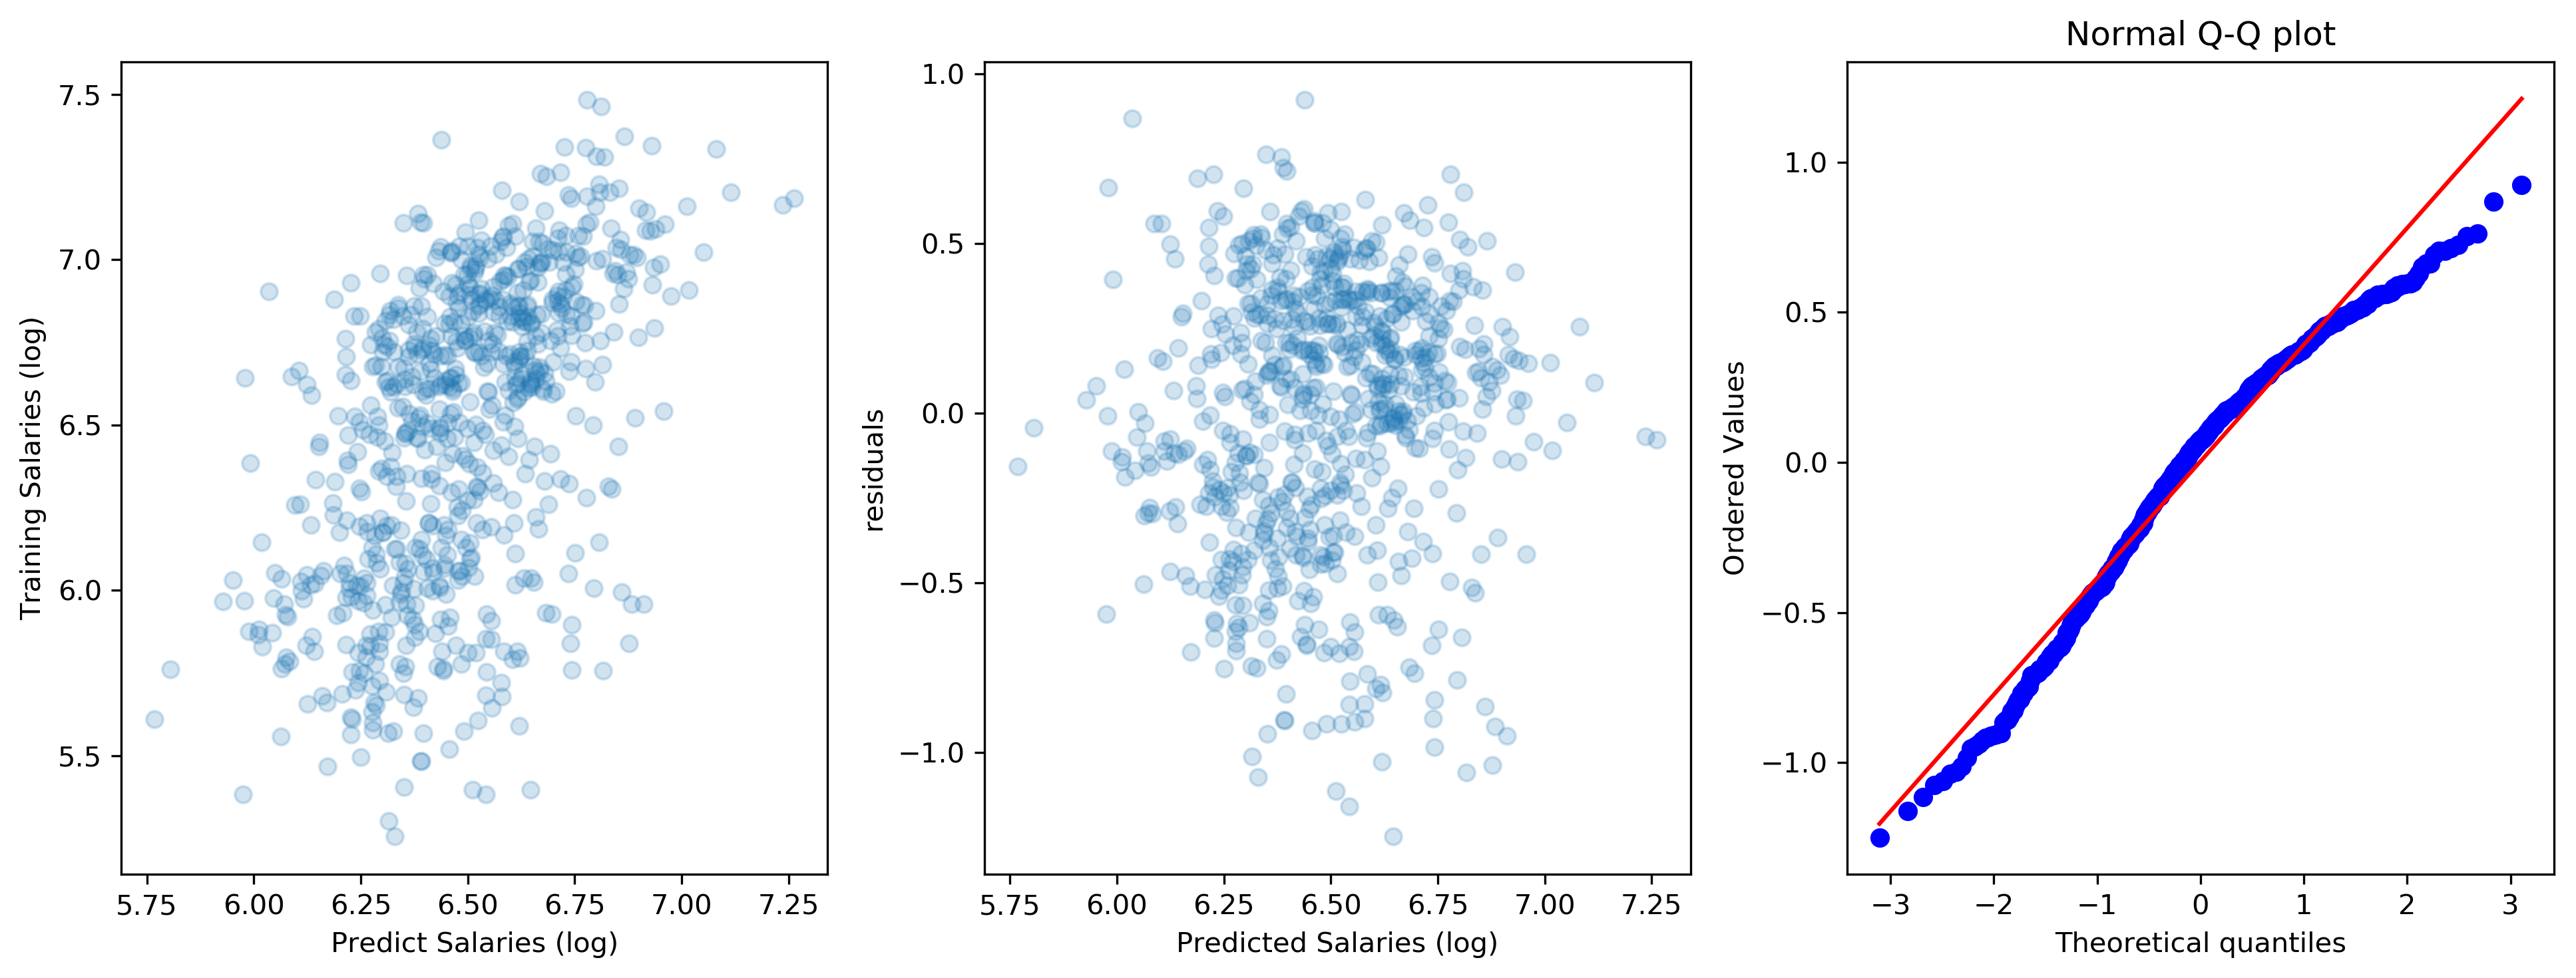

In [187]:
plt.figure(figsize=(13,5))
# plt.subplots(1,3)

# scatter y-train and y-pred
plt.subplot(1,3,1)
plt.scatter(best_model.predict(X_train), y_train, alpha=0.2)
plt.xlabel('Predict Salaries (log)')
plt.ylabel('Training Salaries (log)')

# residual plot
plt.subplot(1,3,2)
res = y_train - best_model.predict(X_train)
plt.scatter(best_model.predict(X_train), res, alpha = 0.2)
plt.xlabel('Predicted Salaries (log)')
plt.ylabel('residuals')

# Q-Q plot
plt.subplot(1, 3, 3)
#Generates a probability plot of sample data against the quantiles of a 
# specified theoretical distribution 
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.savefig('misc/train_fit.png');

In [185]:
print('Train RMSE:', sqrt(mean_squared_error(y_train, best_model.predict(X_train))))
print('Test RMSE:',sqrt(mean_squared_error(y_test, best_model.predict(X_test))), end='\n\n')

print('Train R^2:', best_model.score(X_train, y_train))
print('Test R^2:', best_model.score(X_test, y_test))

Train RMSE: 0.39304760971294495
Test RMSE: 0.3869990483890343

Train R^2: 0.2736447867249906
Test R^2: 0.28522529148287745


In [130]:
y_train.mean()

6.4931755026247036

In [151]:
errors = pd.DataFrame()
errors['observed'] = 10**y_test
errors['predicted'] = 10**best_model.predict(X_test)
errors['error'] = errors.observed - errors.predicted
errors['percent_error'] = errors.error / errors.predicted

errors['salary_average'] = [10**y_train.mean()] * errors.shape[0]
errors['salary_average_error'] = errors.observed - errors.salary_average
errors['salary_average_percent_error'] = errors.salary_average_error / errors.salary_average

In [152]:
errors

,observed,predicted,error,percent_error,salary_average,salary_average_error,salary_average_percent_error
72,5.852346e+05,3.640850e+06,-3.055615e+06,-0.839259,3.112974e+06,-2.527739e+06,-0.812001
120,3.307962e+06,4.424299e+06,-1.116337e+06,-0.252319,3.112974e+06,1.949881e+05,0.062637
296,8.896632e+06,4.376120e+06,4.520512e+06,1.032995,3.112974e+06,5.783658e+06,1.857920
314,9.964228e+05,2.719586e+06,-1.723163e+06,-0.633612,3.112974e+06,-2.116551e+06,-0.679913
710,8.943796e+06,2.601961e+06,6.341835e+06,2.437329,3.112974e+06,5.830822e+06,1.873071
533,8.275410e+05,1.497372e+06,-6.698306e+05,-0.447338,3.112974e+06,-2.285433e+06,-0.734164
869,3.408300e+07,2.903031e+07,5.052688e+06,0.174049,3.112974e+06,3.097003e+07,9.948694
539,1.477752e+07,4.981661e+06,9.795857e+06,1.966384,3.112974e+06,1.166454e+07,3.747074
680,8.007178e+06,3.057641e+06,4.949537e+06,1.618744,3.112974e+06,4.894204e+06,1.572196
468,9.413210e+06,4.313387e+06,5.099823e+06,1.182324,3.112974e+06,6.300236e+06,2.023864


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


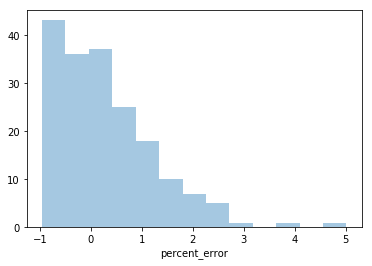

In [139]:
sns.distplot(errors.percent_error, kde=False);

In [153]:
errors['predicted_cats'] = ''
errors['average_cats'] = ''

g = [-10,-0.5, 0.5, 10]# 0.03, 0.06, 0.09, 0.12, 0.15, 10]
l = ['Over-estimated', 'Estimated', 'Under-estimated']# '5-100%', '>100%']#0-25%', '25-50%', '50-75%','50-75%','>100%']
# l = ['Over-valued', 'Valued', 'Under-valued']

for k, b in enumerate(g[:-1]):
    sub = (errors.percent_error >= b) & (errors.percent_error < g[k+1])
    errors.loc[sub,'predicted_cats'] = l[k]
    
    sub = (errors.salary_average_percent_error >= b) & (errors.salary_average_percent_error < g[k+1])
    errors.loc[sub,'average_cats'] = l[k]
    

error_predicted_cat = errors.groupby('predicted_cats')['percent_error'].count().reset_index()
error_average_cat = errors.groupby('average_cats')['percent_error'].count().reset_index()

In [110]:
mean_salary = errors.groupby('cats')['age'].mean().reset_index()
mean_salary

,cats,age
0,Estimated,23.907895
1,Over-estimated,23.767442
2,Under-estimated,24.015385


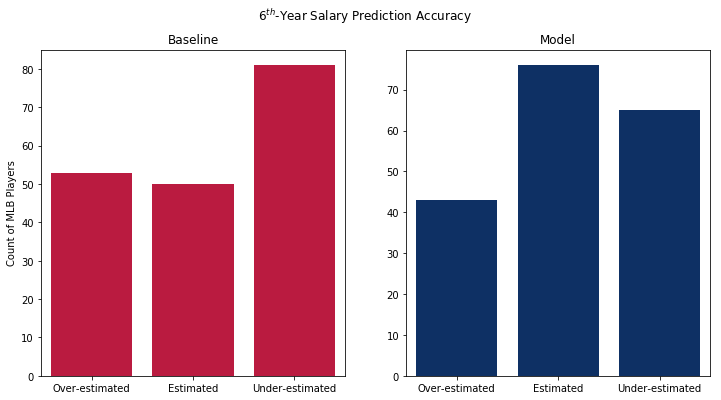

In [160]:
# plt.subplots(1,2)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.barplot(x=error_average_cat.average_cats, y=error_average_cat.percent_error, order=l, color='#D50032')
# plt.axhline(y=4.51e6, color='#002D72', linestyle='--',label='2018 avg. salary')

plt.xlabel('')
plt.ylabel('Count of MLB Players')

plt.title('Baseline')

plt.subplot(1,2,2)
sns.barplot(x=error_predicted_cat.predicted_cats, y=error_predicted_cat.percent_error, order=l, color='#002D72')

plt.xlabel('')
plt.ylabel('')
plt.title('Model')


# convert tick labels to millions
# ax = plt.gca()
# vals = ax.get_yticks()
# ax.set_yticklabels(['{}m'.format(x/1e6) for x in vals])

plt.suptitle('$6^{th}$-Year Salary Prediction Accuracy')
# plt.tight_layout(pad=3)
plt.savefig('misc/salary_prediction_accuracy.png',dpi=300,pad=0);

In [156]:
error_predicted_cat

,predicted_cats,percent_error
0,Estimated,76
1,Over-estimated,43
2,Under-estimated,65


In [157]:
error_average_cat

,average_cats,percent_error
0,Estimated,50
1,Over-estimated,53
2,Under-estimated,81


Estimate is +- 50%, over-estimate is worse than -50%, and under_estimate is greater than 50% error. The baseline model (right) is only able to get 27% of the 184 randomly selected players in the estimated range. Whereas, my model was able to get 41% within the estimated range. This ia statistically significant shift in the right direction. Clearly there is more to be refined as there is still significant numebr of players which are being under or over estimated with my model. However, this model will provide more information than taking a simply average of a random set of player's salaries in year 6. You can use this model as a guide plus you industry knowledge to assess the direction to take a negotiation.

You can see using current stats does provide an inital value estimate for the rookie player. You can then start to add cumulative stats each year.

In [103]:
coefs = pd.DataFrame(data = best_model.get_params()['lasso'].coef_, index = best_model.get_params()['polynomialfeatures'].get_feature_names(X_train.columns))

In [106]:
coefs[coefs.iloc[:,0] != 0]

,0
age,-0.174874
G^2,-0.034479
G age,-0.028781
R age^2,0.032096
SB^2 HR,0.009415
SB 3B BB,0.012880
SB BB^2,0.007684
HR age^2,0.098267
TB age^2,0.024179
2B age^2,0.026535


In [180]:
bad_errors = errors[errors.cats=='>100%'].sort_values('percent_error')
bad_errors

AttributeError: 'DataFrame' object has no attribute 'cats'

In [181]:
salary_stats_df.loc[salary_stats_df.name=='Bryce Harper']

,rookie_year,age,name,debut,position,G,PA,AB,R,H,...,2B,3B,RBI,BB,SO,name_year,Salary,SrvTm,today_salary,log_today_salary
867,2012,19.0,Bryce Harper,2012-04-28,Outfielder,139.0,597.0,533.0,98.0,144.0,...,26.0,9.0,59.0,56.0,120.0,Bryce Harper_2012,21625000.0,5.159,21625000.0,7.334956


In [ ]:
train_errors = pd.DataFrame()
train_errors['observed'] = 10**y_train
train_errors['predicted'] = 10**best_model.predict(X_train)
train_errors['error'] = train_errors.observed - train_errors.predicted
train_errors['percent_error'] = (train_errors.observed - train_errors.predicted) / train_errors.predicted

In [ ]:
train_errors.loc[867]

In [ ]:
[y_test[880],10**y_test[880]]

In [ ]:
salary_stats_df.loc[880,['log_today_salary','today_salary']]

In [ ]:
salary_stats_df.join(bad_errors,how='inner').describe()

In [ ]:
salary_stats_df.sort_values('today_salary',ascending=False)

In [186]:
best_model.fit(X,y)
print('RMSE:', sqrt(mean_squared_error(y, best_model.predict(X))))
print('R^2:', best_model.score(X,y))

RMSE: 0.3918440565947047
R^2: 0.2760381001440161
